### How to save documents as pkl files

In [68]:
pickle_df = pd.read_pickle('section_df.pkl')

In [77]:
section.to_pickle('section_df.pkl')
full_df.to_pickle('final_df.pkl')

### Necessary packages 
#### Make sure to go to bottom and run all necessary functions

In [1]:
from tkinter import Tk, filedialog
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import scipy
import gensim
from gensim.models import FastText

import csv

import random

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [2]:
from gensim.models.word2vec import LineSentence

In [3]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [4]:
import math

In [15]:
glove_file = datapath(file)
word2vec_glove_file = get_tmpfile("glove.6B.300d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

(400001, 300)

In [54]:
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

### Use the cell below to read in all your parse syllabi csv files to combine

In [31]:
root = Tk()
root.filename = filedialog.askopenfilename()
file = root.filename
root.withdraw()

''

In [26]:
pdf_df = pd.read_csv(file)

In [24]:
htm_df = pd.read_csv(file)

In [28]:
doc_df = pd.read_csv(file)

In [30]:
description_df = pd.read_csv(file)

In [239]:
descr_dict ={}
for i in range(len(description_df['CLASS'])):
    course = list(description_df['CLASS'])[i]
    description = list(description_df['CATALOG_DESCRIPTION'])[i]
    if len(str(description)) < 4:
        continue
    if course in course_avg:
        descr_dict[course] = calculate_w2v_avg(description)

C:\Users\simon\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\simon\Anaconda3\Lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Creating Edge list df 

In [39]:
loop = 0
main_dict = {'pre-req': [], 'post-req': []}
with open(file, newline = '', encoding='utf-8') as games:                                                                                          
    game_reader = csv.reader(games, delimiter='\t')
    for game in game_reader:
        if loop == 0:
            loop+=1
            continue
        main_dict['pre-req'].append(game[0])
        main_dict['post-req'].append(game[1])
edge_df = pd.DataFrame(main_dict)

In [40]:
pre_req = edge_df['pre-req'].tolist()
post_req = edge_df['post-req'].tolist()
new_dict = {'pre-req': [], 'post-req': []}
numbers = '0123456789'
for course in pre_req:
    begin = 0
    while course[begin] not in numbers:
        begin+= 1
    new_dict['pre-req'].append(course[:begin] + '-' + course[begin:])
for course in post_req:
    begin = 0
    while course[begin] not in numbers:
        begin+= 1
    new_dict['post-req'].append(course[:begin] + '-' + course[begin:])
new_edge = pd.DataFrame(new_dict)

### Create scrambled edge list 

In [42]:
new_req = random.sample(list(new_edge['pre-req']), len(list(new_edge['pre-req'])))

In [43]:
og_edge = new_edge.copy()

In [44]:
og_edge['pre-req'] = new_req

In [45]:
og_edge

,pre-req,post-req
0,MATH-121,AA-100
1,ENGR-15,AA-100
2,CEE-164,AA-100
3,EE-101B,AA-100
4,AMELANG-128B,AA-200
...,...,...
2844,AMELANG-140B,TAPS-232
2845,CHEMENG-185A,TAPS-233
2846,ARTSTUDI-179,TAPS-234
2847,MATH-51,URBANST-133


### Combine the two edge frames

In [46]:
all_edges = pd.concat([new_edge, og_edge], axis=0).reset_index(drop=True)

In [47]:
all_edges

,pre-req,post-req
0,MATH-20,AA-100
1,MATH-21,AA-100
2,MATH-41,AA-100
3,MATH-42,AA-100
4,AA-210A,AA-200
...,...,...
5693,AMELANG-140B,TAPS-232
5694,CHEMENG-185A,TAPS-233
5695,ARTSTUDI-179,TAPS-234
5696,MATH-51,URBANST-133


### Calculate embedding for everything

In [57]:
syllabi_embedding = []
description_embedding = []
for syllabi in full_df['syllabi']:
    syllabi_embedding.append(calculate_w2v_avg(syllabi))
for description in full_df['Description']:
    description_embedding.append(calculate_w2v_avg(description))

In [58]:
full_df['syllabi_embed'] = syllabi_embedding
full_df['description_embed'] = description_embedding

In [63]:
full_df.to_csv('final_df.csv', index=False, header=True)

### 80-20 split test set-up for classification

In [112]:
# requisite_df
syll_test = []
descr_test = []
sjac_test = []
djac_test = []
related_test = []
count = len(requisite_df['pre-req'])
test_count = count * 0.2
syllabi_sim = list(requisite_df['syllabi-sim'])
descr_sim = list(requisite_df['descr-sim'])
sjac_sim= list(requisite_df['syllabi_jac_sim'])
djac_sim = list(requisite_df['descr_jac_sim'])
related_list = list(requisite_df['related'])

for i in range(int(test_count)):
    index = np.random.randint(count)
    syll_test.append(syllabi_sim[index])
    del syllabi_sim[index]
    descr_test.append(descr_sim[index])
    del descr_sim[index]
    sjac_test.append(sjac_sim[index])
    del sjac_sim[index]
    djac_test.append(djac_sim[index])
    del djac_sim[index]
    related_test.append(related_list[index])
    del related_list[index]
    
    count -= 1

### Training and using classifier

In [113]:
regression_file = open('regression_report.txt', 'a')
regression_file.write('\n\n')
regression_file.write('Cosine Simmilarity Regression Classification With Test Set Outside of Training Set')
regression_file.write('\n')

1

In [120]:
regression_file.write('\n\n')
regression_file.write('Jaccard Simmilarity Regression Classification With Test Set Outside of Training Set')
regression_file.write('\n')

1

In [121]:
model = LogisticRegression()
x = mirror([sjac_sim, djac_sim])
model.fit(x, list(related_list))

LogisticRegression()

In [122]:
x = mirror([sjac_test, djac_test])
regression_file.write('\n')
regression_file.write('The array of what the model predicted: (refer to requite_training_df.csv to compare accuracy)')
regression_file.write('\n')
regression_file.write(str(model.predict(x)))

815

In [123]:
regression_file.write('\n')
regression_file.write('The model probabilities')
regression_file.write('\n')
regression_file.write(str(model.predict_proba(x)))

10050

In [124]:
x = mirror([sjac_sim, djac_sim])
regression_file.write('\n')
regression_file.write('The average accuracy')
regression_file.write('\n')
regression_file.write(str(model.score(x, related_list)))
# the average

18

In [125]:
regression_file.close()

### Combining the parsed syllabi documents and calculating small metrics

In [35]:
combined = pd.concat([doc_df, pdf_df, htm_df], axis=0)

In [36]:
left_merge = combined.merge(description_df, on='CLASS', how='left')

In [39]:
descr = left_merge['CATALOG_DESCRIPTION'].tolist()
syll = left_merge['syllabi'].tolist()
jacc_sim = []
for i in range(len(descr)):
    if descr[i] is np.nan:
        jacc_sim.append(0)
        continue
    description = descr[i].split()
    syllabus = syll[i].split()
    jac_ind = jaccard_similarity(description, syllabus)
    jacc_sim.append(jac_ind)

left_merge['jaccard_similarity'] = jacc_sim

In [40]:
length = []
descr_length = []
for syllabi in list(left_merge['syllabi']):
    length.append(len(syllabi))

    
left_merge['Syllabi_length'] = length


In [41]:
cosine_sim = []
for i in range(len(left_merge['syllabi'])):

    try:
        vector_descr = calculate_w2v_avg(list(left_merge['CATALOG_DESCRIPTION'])[i])
    except:
        cosine_sim.append(0)
        continue
    vector_syll = calculate_w2v_avg(list(left_merge['syllabi'])[i])
    cosine_sim.append(1 - scipy.spatial.distance.cosine(vector_syll, vector_descr))

C:\Users\simon\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\simon\Anaconda3\Lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
left_merge['Cosine_Similarity'] = cosine_sim

In [43]:
left_merge.sort_values(by='Cosine_Similarity', ascending=False)

,Year,Section,Quarter,department,CLASS,syllabi,website_count,SUBJECT,CATALOG_NBR,CATALOG_DESCRIPTION,jaccard_similarity,Syllabi_length,Cosine_Similarity
25970,2009,02,Winter,OB,OB-368,ideas stick session preparation questions page...,0,OB,368,"having a good idea is not enough, we must also...",0.013722,21949,0.954557
25969,2009,01,Winter,OB,OB-368,ideas stick session preparation questions page...,0,OB,368,"having a good idea is not enough, we must also...",0.013722,21949,0.954557
16861,2013,01,Fall,ENERGY,ENERGY-171,richard sears green earth sciences bldg energy...,0,ENERGY,171,oil and gas represents more than 50% of global...,0.083784,2468,0.953211
16864,2013,01,Fall,ENERGY,ENERGY-271,richard sears green earth sciences bldg energy...,0,ENERGY,271,oil and gas represents more than 50% of global...,0.083784,2468,0.953211
3279,2014,01,Fall,ENERGY,ENERGY-271,energy resources engineering energy infrastruc...,0,ENERGY,271,oil and gas represents more than 50% of global...,0.083784,2462,0.952864
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32056,2015,01,Winter,POLISCI,POLISCI-203,human rights ngo international human rights dr...,0,NaN,NaN,NaN,0.000000,571,NaN
32064,2016,01,Winter,LAW,LAW-266A,stanford law school juelsgaard intellectual pr...,0,NaN,NaN,NaN,0.000000,17827,NaN
32065,2016,01,Winter,LAW,LAW-266B,stanford law school juelsgaard intellectual pr...,0,NaN,NaN,NaN,0.000000,17827,NaN
32066,2016,01,Winter,LAW,LAW-266C,stanford law school juelsgaard intellectual pr...,0,NaN,NaN,NaN,0.000000,17827,NaN


### Creating box plots for course departments

In [62]:
jac_sim = left_merge[['department', 'jaccard_similarity']]

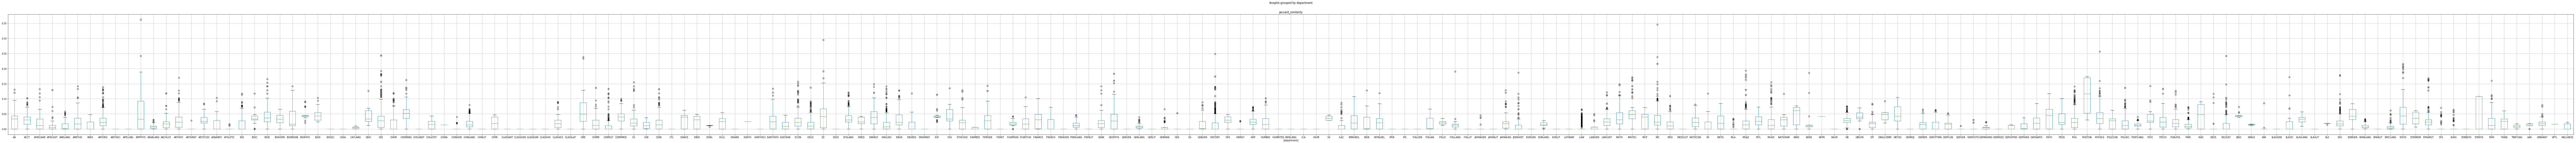

In [67]:
jac_sim.boxplot(by='department', figsize=(200, 10))
plt.savefig('jac_sim_plot.png', bbox_inches='tight')

In [119]:
web_count = left_merge[['department', 'website_count']]

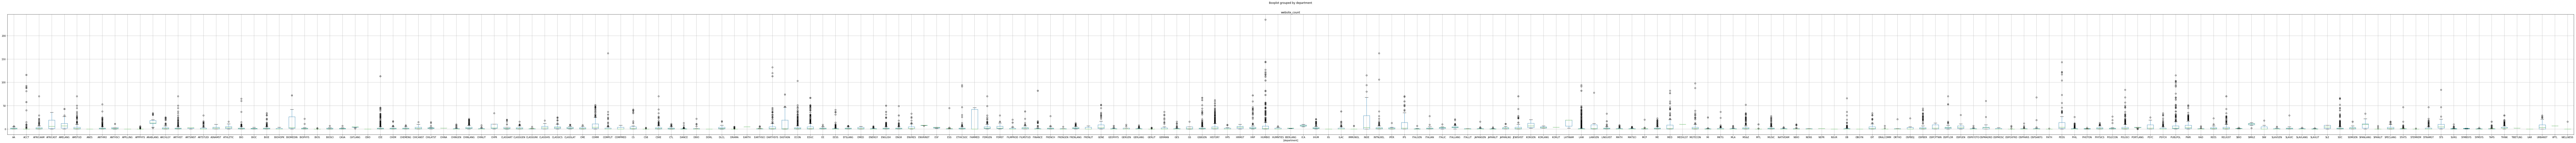

In [120]:
web_count.boxplot(by='department', figsize=(200, 10))
plt.savefig('web_count_plot.png', bbox_inches='tight')

In [121]:
length = left_merge[['department', 'Syllabi_length']]

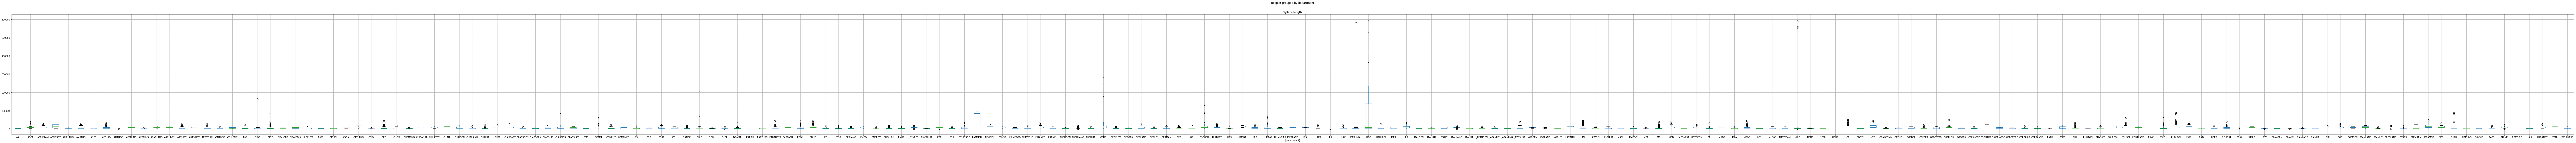

In [122]:
length.boxplot(by='department', figsize=(200, 10))
plt.savefig('length_plot.png', bbox_inches='tight')

In [134]:
cosine_sim = left_merge[['department', 'Cosine_Similarity']]

C:\Users\simon\Anaconda3\Lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


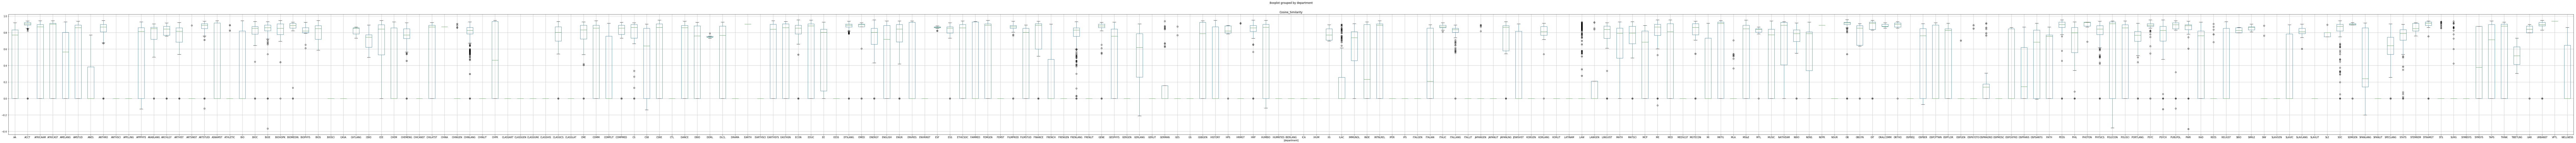

In [135]:
cosine_sim.boxplot(by='department', figsize=(200, 10))
plt.savefig('cos_sim_plot.png', bbox_inches='tight')

### Calculate distance from course average

In [52]:
average_list = [0 for x in range(len(section['CLASS']))]
avg_dis = [0 for x in range(len(section['CLASS']))]
for course in section_list:
    temp_df = section[section['CLASS'] == course]
    temp_list = []
    temp_dict = {}
    for syllabi in list(temp_df['syllabi']):
        temp_dict[syllabi] = calculate_w2v_avg(syllabi)
        temp_list.append(temp_dict[syllabi])
    avg = np.average(temp_list, axis=0)
    for i in range(len(section['CLASS'])):
        if section['CLASS'][i] == course:
            avg_dis[i] = 1 - scipy.spatial.distance.cosine(temp_dict[section['syllabi'][i]], avg)
            average_list[i] = avg

C:\Users\simon\Anaconda3\Lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\simon\Anaconda3\Lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\simon\Anaconda3\Lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [63]:
section['Distance_From_AVG'] = avg_dis
section['Course_w2v_AVG'] = average_list

### Necessary functions

In [86]:
def year_avg(years, df):
    year_web = []
    for i, row in df.iterrows():
        year = list(df['Year'])[i]
        js = list(df['jaccard_similarity'])[i]
        year_web.append((year, js))
                    
    year_avg= []
    for year in years:
        temp_list = []
        for tup in year_web:
            if year == tup[0]:
                temp_list.append(tup[1])
        year_avg.append(np.average(temp_list))
        
    return year_avg

In [33]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [77]:
def course_embed_avg(course):
    temp_df = full_df[full_df['CLASS'] == course]
    temp_list = []
    for i in range(len(temp_df['syllabi'])):
        temp_list.append(full_df['syllabi_embed'][i])
    return np.average(temp_list)

In [82]:
def mirror(matrix):
    final_list = []
    for i in range(len(matrix[0])):
        final_list.append([matrix[0][i], matrix[1][i]])
    return np.array(final_list)     

In [34]:
def calculate_w2v_avg(text):
    grand_vector = []
    if len(str(text)) < 4:
        return np.nan
    for word in text.split():
        try:
            # if "model[word]" is not grabbing proper embedding, try creating an embedding dictionary by using the embedding file
            grand_vector.append(np.array(model[word]).astype(np.float))
        except:
            continue
    return np.average(grand_vector, axis=0)